## This notebook compiles different experiments made to test the main pipeline, and different functions 

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import re

from functions.EpiIndex import *
from functions.Connectivity import *
from functions.Connectivity import calculate_and_plot_granger_causality
from scipy.signal import hilbert

from PIL import Image
import io
from itertools import cycle
from matplotlib.lines import Line2D
from scipy.fft import fft, fftfreq

## Pipeline Preprocessing (Final state) experiments

#### Line noise Removal 

In [2]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)
#Getting the total time of the recording
total_time = raw.times[-1]
#Getting the sampling frequency
sfreq = raw.info['sfreq']
#Getting the number of channels
n_channels = raw.info['nchan']


sampling_rate = sfreq  # Hz
T = 1.0 / sampling_rate  # Sample spacing
t = np.arange(0, int(total_time), T)

signal1 = raw.get_data()[40]


# # Find the power line frequency
# # Threshold to identify prominent peaks in the spectrum (e.g., power line frequency)
# miu_s=np.linspace(0.6,0.95,7)

# means=[]

# for miu in miu_s:

#     power_line_freqs_pos=[]
#     for ch in range(n_channels):
#         # Simulating a signal with power line interference at 50 Hz and its harmonics
#         signal = raw.get_data()[ch]

#         # Perform FFT
#         N = len(t)  # Number of samples
#         yf = fft(signal)  # Compute the fast Fourier transform
#         xf = fftfreq(N, T)[:N // 2]  # Frequencies corresponding to the FFT result

#         # Get the magnitude of the FFT (only positive frequencies)
#         magnitude = np.abs(yf[:N // 2])
#         threshold = np.max(magnitude) * miu

#     # # Plot the frequency spectrum
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(xf, magnitude)
#     # plt.title('Frequency Spectrum of the Signal')
#     # plt.xlabel('Frequency (Hz)')
#     # plt.ylabel('Magnitude')
#     # plt.grid(True)
#     # plt.show()

#     # #plot signal 
#     # plt.figure(figsize=(10, 6))
#     # plt.plot(t, signal[:len(t)])
#     # plt.title('Signal with Power Line Interference')
#     # plt.xlabel('Time (s)')
#     # plt.ylabel('Amplitude')
#     # plt.grid(True)
#     # plt.show()

#     # You can adjust the threshold

#     # Find frequencies where magnitude exceeds the threshold
#         power_line_freqs = xf[magnitude > threshold]
#         power_line_freqs_pos.append(power_line_freqs[power_line_freqs>0])
    
#     means.append(np.mean(np.concatenate(power_line_freqs_pos)))

# # print(f"Possible Power Line Frequencies Detected: {power_line_freqs_pos}")

# np.arange(1, 5) * np.mean(means)



Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif...


Isotrak not found
    Range : 4681728 ... 4866048 =   9144.000 ...  9504.000 secs
Ready.


/tmp/ipykernel_60794/2948548438.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/pte_01/sets/segments_ictal_SR/ictal-epo_6.fif', preload=True)


Reading 0 ... 184320  =      0.000 ...   360.000 secs...


## Reading xyz schema

In [3]:
#Reading .tsv file 
xyz_loc = pd.read_csv('/home/pablo/works/dev_thesis_SEEG/data/pte_01/others/sEEG_locs.tsv', sep='\t')


def format_label(label):
    # Remove 'EEG '
    label = label.replace('EEG ', '').strip()
    # Use regular expressions to insert apostrophe before the number
    label = re.sub(r'(\D+)(\d+)', r"\1'\2", label)
    return label.lower()

xyz_loc['formatted_label']=xyz_loc['label'].apply(format_label)


#Find intersection of xyz_loc['formatted_label'] and epochs.ch_names
intersection = set(xyz_loc['formatted_label']).intersection(raw.ch_names)

# Filter the dataframe to keep only the intersecting labels
df_filtered = xyz_loc[xyz_loc['formatted_label'].isin(intersection)]

# Reorder the dataframe according to chnames (which will now only contain the intersecting labels)
df_filtered = df_filtered.set_index('formatted_label')

#Getting to know which inndexes from the original to eliminate 
cd=pd.Series(raw.ch_names).isin(intersection)
idx=cd.index[~cd].tolist()

#Eliminating the channels which are not in the intersection

channels_to_drop=[raw.ch_names[item] for item in idx]

raw.drop_channels(channels_to_drop)

xyz_loc = xyz_loc.set_index('formatted_label').reindex(raw.ch_names).reset_index()

#Save the xyz_loc file
xyz_loc.to_csv('/home/pablo/works/dev_thesis_SEEG/data/pte_01/others/sEEG_locs_filtered.tsv', sep='\t', index=False)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 110.00 Hz
- Upper transition bandwidth: 27.50 Hz (-6 dB cutoff frequency: 123.75 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 s)



[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 112 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 122 out of 122 | elapsed:    1.4s finished


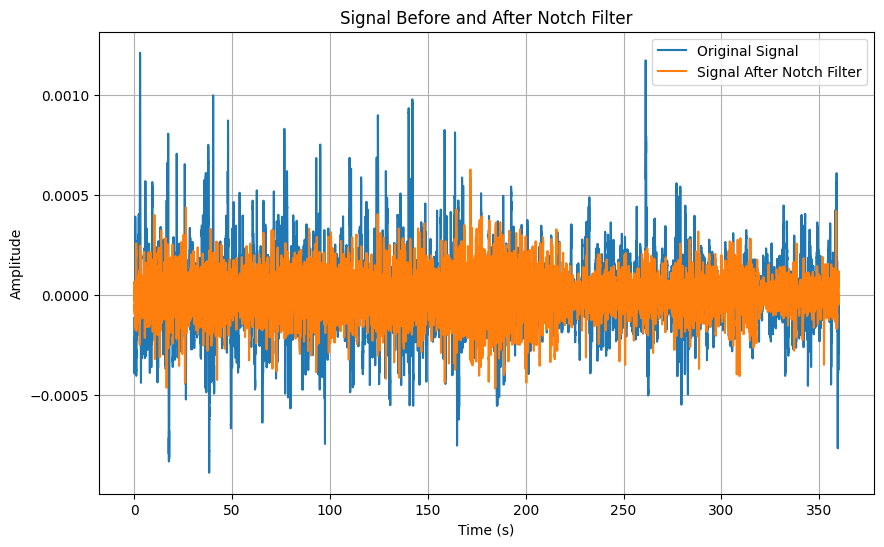

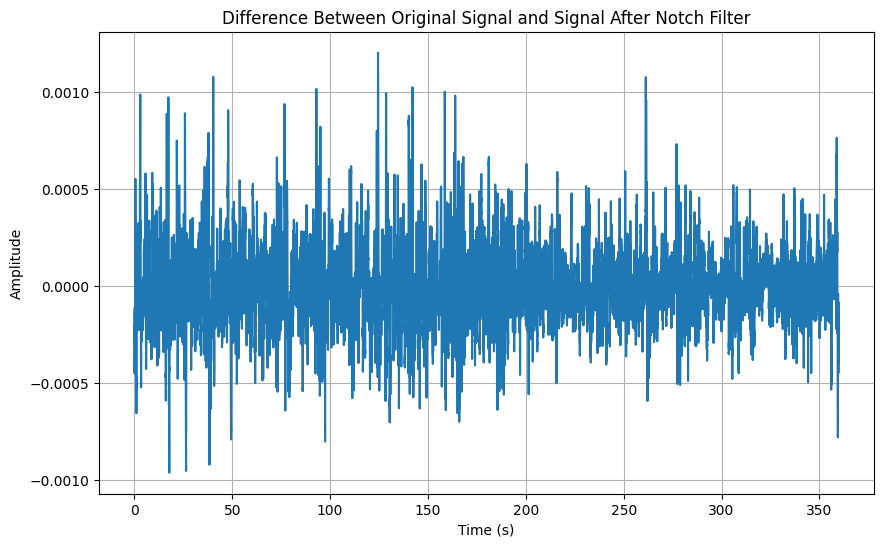

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)


/tmp/ipykernel_60794/376316438.py:28: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(ax=ax[0], color='blue',average=True)
/home/pablo/miniconda3/envs/Epilep/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Plotting power spectral density (dB=True).


/tmp/ipykernel_60794/376316438.py:29: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_notch.plot_psd(ax=ax[1], color='red',average=True)


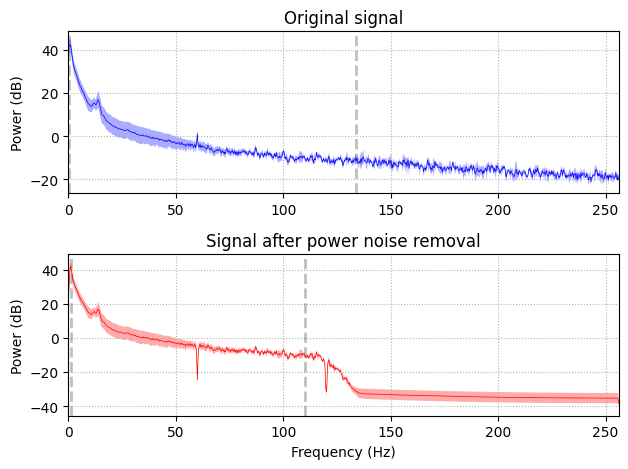

In [4]:
raw_=raw.copy().filter(l_freq=1, h_freq=110)

#Aplying a bandstop filter to remove the power line interference using notch
raw_notch=raw_.copy().notch_filter(freqs=[60,120,180],filter_length='auto',phase='zero',verbose=True,n_jobs=4,fir_window='hamming')
#Compare the signal before and after the notch filter
plt.figure(figsize=(10, 6))
plt.plot(t, signal1[:len(t)], label='Original Signal')
plt.plot(t, raw_notch.get_data()[0][:len(t)], label='Signal After Notch Filter')
plt.title('Signal Before and After Notch Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


#Difference between the original signal and the signal after the notch filter
plt.figure(figsize=(10, 6))
plt.plot(t, signal1[:len(t)] - raw_notch.get_data()[0][:len(t)])
plt.title('Difference Between Original Signal and Signal After Notch Filter')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

fig, ax = plt.subplots(2)

raw.plot_psd(ax=ax[0], color='blue',average=True)
raw_notch.plot_psd(ax=ax[1], color='red',average=True)

ax[0].set_title('Original signal')
ax[0].set_ylabel('Power (dB)')
ax[1].set_title('Signal after power noise removal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Power (dB)')

fig.set_tight_layout(True)
plt.show()

In [5]:
 # # # Epoching
t_sec=raw.n_times/raw.info['sfreq']
epochs=mne.make_fixed_length_epochs(raw_notch, duration=30, preload=True)

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 15360 original time points ...
0 bad epochs dropped


In [6]:
# Threshold for identifying high amplitude transients
threshold = 3000  # in microvolts (µV)

# Create a list to store the indices of epochs with high amplitude transients
bad_epochs = []

# Iterate over epochs
for i, epoch in enumerate(epochs):
    # Check if the absolute value of any sample in the epoch exceeds the threshold
    if np.max(np.abs(epoch)) > threshold:
        bad_epochs.append(i)

In [7]:
frequency_bands = {
    'theta': (4, 8),
    'alpha': (8, 12),
    'beta': (15, 25),
    'low_gamma': (35, 50),
    'high_gamma1': (70, 100),
    }

filtered_epochs = {}
for band, (l_freq, h_freq) in frequency_bands.items():
    filtered_epochs[band] = epochs.copy().filter(l_freq, h_freq,fir_design='firwin',n_jobs=5,
                                                 verbose=False, phase='zero-double')


In [7]:
# # plt.figure(figsize=(15, 30))

# # Plot PSD for each frequency band
# for i, (band, epochs) in enumerate(filtered_epochs.items(), start=1):
#     psd = epochs.compute_psd(fmin=1, fmax=256)  # Compute the PSD
#     psd.plot(show=False)  # Plot the PSD
#     plt.title(f'PSD of {band} band')
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel('Power/Frequency (dB/Hz)')
    

#     # Adjust layout and show plot
#     plt.tight_layout()
#     plt.show()

/tmp/ipykernel_217519/3361681113.py:4: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  time = np.linspace(0, epoch_length, filtered_epochs[band].get_data().shape[2])
/tmp/ipykernel_217519/3361681113.py:8: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epoch_data = filtered_epochs[band].get_data()[ep]  # Shape: (127, 3072)


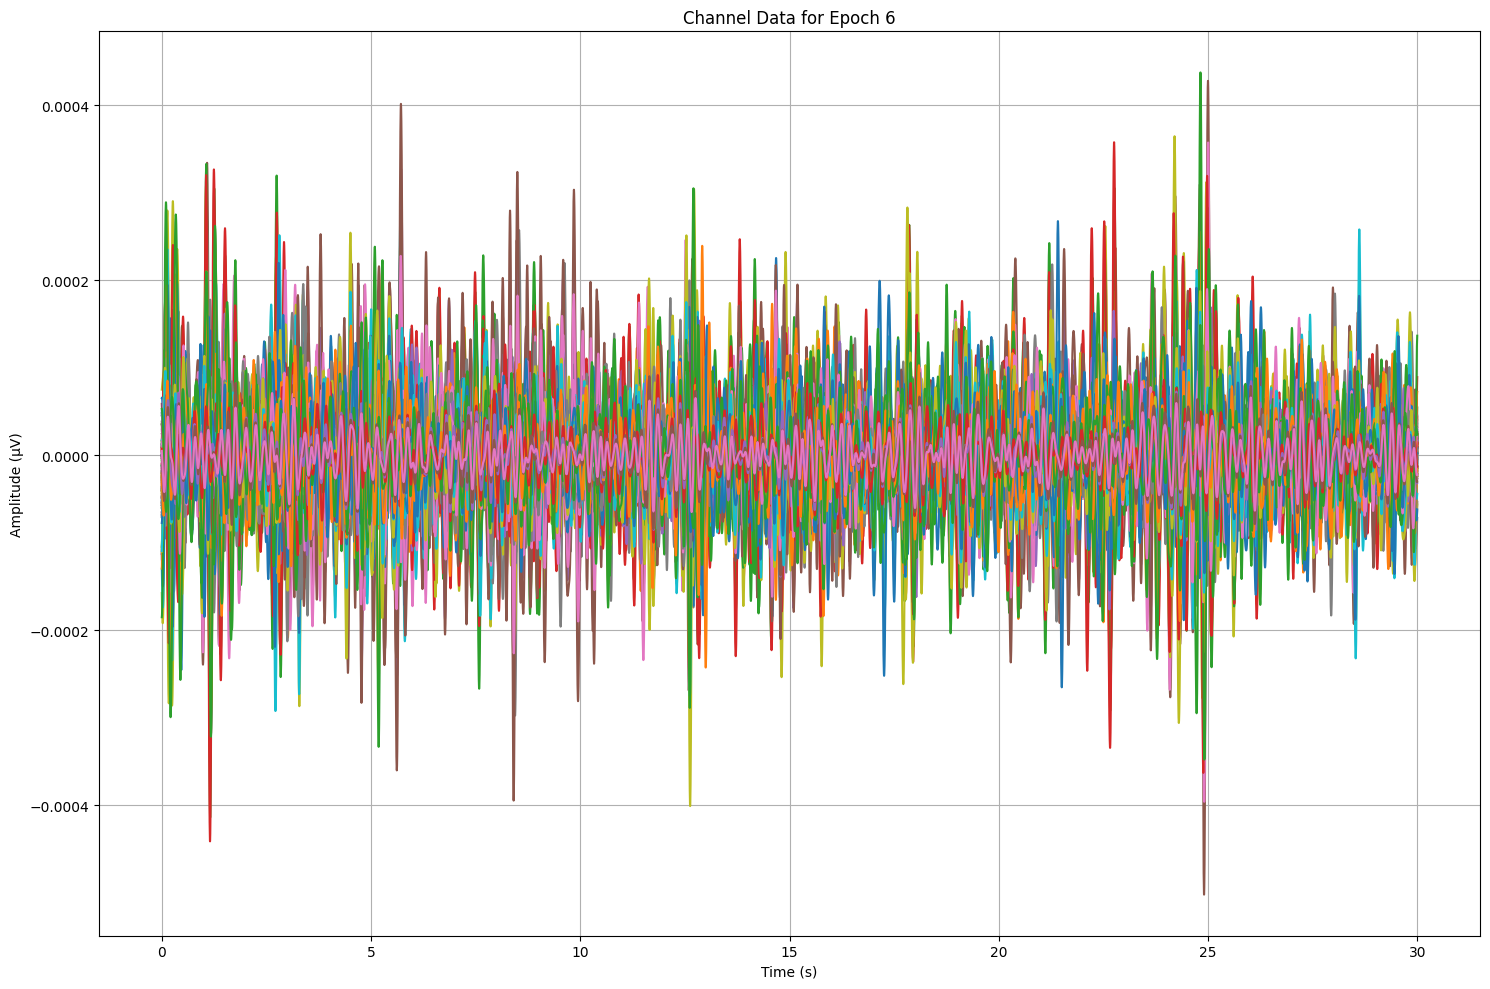

In [26]:

sampling_rate = 512  # Hz
epoch_length = 60  # seconds
band='theta'
time = np.linspace(0, epoch_length, filtered_epochs[band].get_data().shape[2])

# Select the epoch you want to plot (e.g., ep = 0 for the first epoch)
ep = 6
epoch_data = filtered_epochs[band].get_data()[ep]  # Shape: (127, 3072)

# Plotting
plt.figure(figsize=(15, 10))

for channel in range(epoch_data.shape[0]):
    plt.plot(time, epoch_data[channel], label=f'Channel {channel + 1}')  # Offset each channel for visibility

plt.title(f'Channel Data for Epoch {ep}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
# Function for mirror padding and Hilbert transform
def apply_hilbert_transform(epoch_data):
    # Mirror padding the epoch data (pad by mirroring the first and last samples)
    padding_length = 1000  # Padding with half of the epoch length
    padded_data = np.pad(epoch_data, ((0, 0), (padding_length, padding_length)), mode='reflect')

    # Apply Hilbert transform
    analytic_signal = hilbert(padded_data, axis=1)

    # Trim the padding to retrieve the original epoch length
    trimmed_analytic_signal = analytic_signal[:, padding_length:-padding_length]
    envelop=np.abs(trimmed_analytic_signal)
    # phase=np.angle(trimmed_analytic_signal)

    return trimmed_analytic_signal,envelop

# Apply to all epochs and channels in a specific band (e.g., 'low_gamma')

hilbert_transformed_data_bands={}
envelop_data_bands={}
# phase_data_bands={}
for bands in filtered_epochs.keys():
    hilbert_transformed_data = []
    envelop_list=[]
    # phase_list=[]
    for epoch_data in filtered_epochs[bands].get_data():
        transformed_epoch,envelop = apply_hilbert_transform(epoch_data)
        hilbert_transformed_data.append(transformed_epoch)
        envelop_list.append(envelop)
        # phase_list.append(phase)

    hilbert_transformed_data = np.array(hilbert_transformed_data)  # Shape: (n_epochs, n_channels, epoch_length)
    hilbert_transformed_data_bands[bands]=hilbert_transformed_data
    envelop_list=np.array(envelop_list)
    envelop_data_bands[bands]=envelop_list
    # phase_list=np.array(phase_list)
    # phase_data_bands[bands]=phase_list

/tmp/ipykernel_610706/1601809492.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch_data in filtered_epochs[bands].get_data():
/tmp/ipykernel_610706/1601809492.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch_data in filtered_epochs[bands].get_data():
/tmp/ipykernel_610706/1601809492.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch_data in filtered_epochs[bands].get_data():
/tmp/ipykernel_610706/1601809492.py:26: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  for epoch_data in filtered_epochs[bands].get_data():
/tmp/ipykernel_610706/1601809492.py:26: FutureWarning: The current defau

In [9]:
def calculate_aec(amplitude_envelopes):
    n_channels = amplitude_envelopes.shape[0]
    aec_matrix = np.zeros((n_channels, n_channels))
    
    for i in range(n_channels):
        for j in range(i, n_channels):
            correlation = np.corrcoef(amplitude_envelopes[i], amplitude_envelopes[j])[0, 1]
            aec_matrix[i, j] = correlation
            aec_matrix[j, i] = correlation  # Symmetric matrix
            
    return aec_matrix

# Calculate AEC for each frequency band and epoch
aec_results = {}
for band, envelopes in envelop_data_bands.items():
    aec_results[band] = []
    for envelope in envelopes:
        aec_matrix = calculate_aec(envelope)
        aec_results[band].append(aec_matrix)
    aec_results[band] = np.array(aec_results[band])


## Reading xyz schema

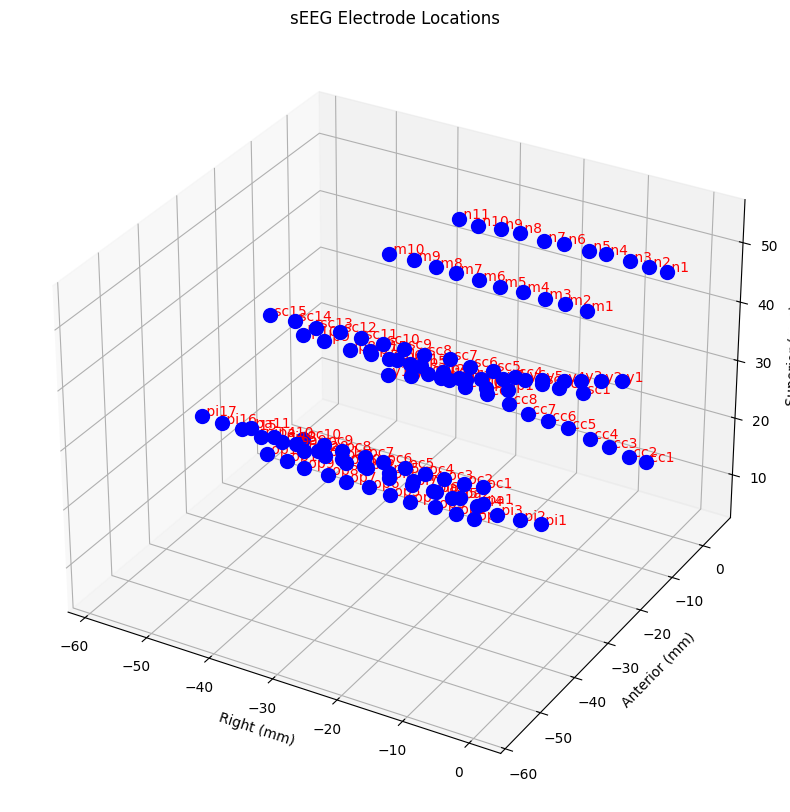

In [11]:
#Plot the electrodes ubications in a x,y,z 3D space
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each electrode as a point
for i, row in xyz_loc.iterrows():
    ax.scatter(row['r'], row['a'], row['s'], color='b', s=100)

# Annotate each electrode with its name, without the "EEG" prefix and lowercase
for i, row in xyz_loc.iterrows():
    ax.text(row['r'], row['a'], row['s'], row['label'][3:].lower(), color='r')
# Set labels and title
ax.set_xlabel('Right (mm)')
ax.set_ylabel('Anterior (mm)')
ax.set_zlabel('Superior (mm)')
ax.set_title('sEEG Electrode Locations')

plt.show()

In [5]:
#Getting the matrix distance of every set of electrodes, where the name of a set of electrodes 
#is given by the name of the column in the xyz_loc dataframe without the "EEG" prefix and number

#get the names of the electrodes 
electrodes_names = xyz_loc['formatted_label'].values


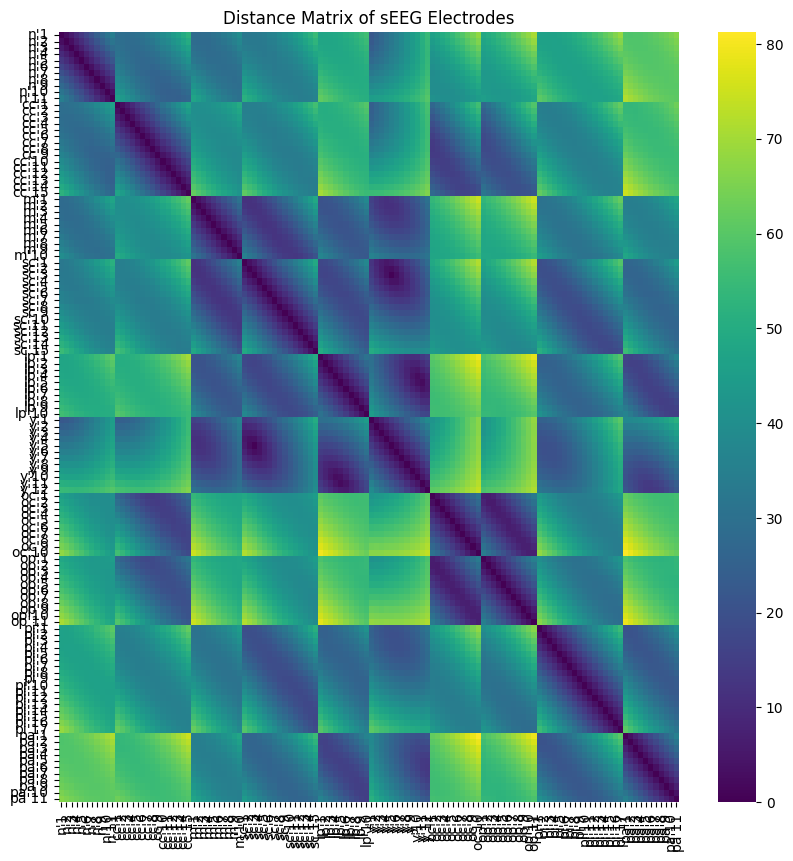

In [6]:
#Get the euclidean distance between each pair of electrodes
distances = pairwise_distances(xyz_loc[['r', 'a', 's']])
#create a matrix plot of the distances
plt.figure(figsize=(10, 10))
sns.heatmap(distances, xticklabels=electrodes_names, yticklabels=electrodes_names, cmap='viridis')
plt.title('Distance Matrix of sEEG Electrodes')
plt.show()


In [7]:
#Save distance matrix 
np.save('/home/pablo/works/dev_thesis_SEEG/data/pte_01/others/distance_matrix.npy', distances)

In [17]:
#Normalize between 0 and 1
def normalize_matrix(matrix):
    min_value = np.min(matrix)
    max_value = np.max(matrix)
    normalized_matrix = (matrix - min_value) / (max_value - min_value)
    return normalized_matrix

# Normalize the distance matrix
normalized_distances = normalize_matrix(distances)


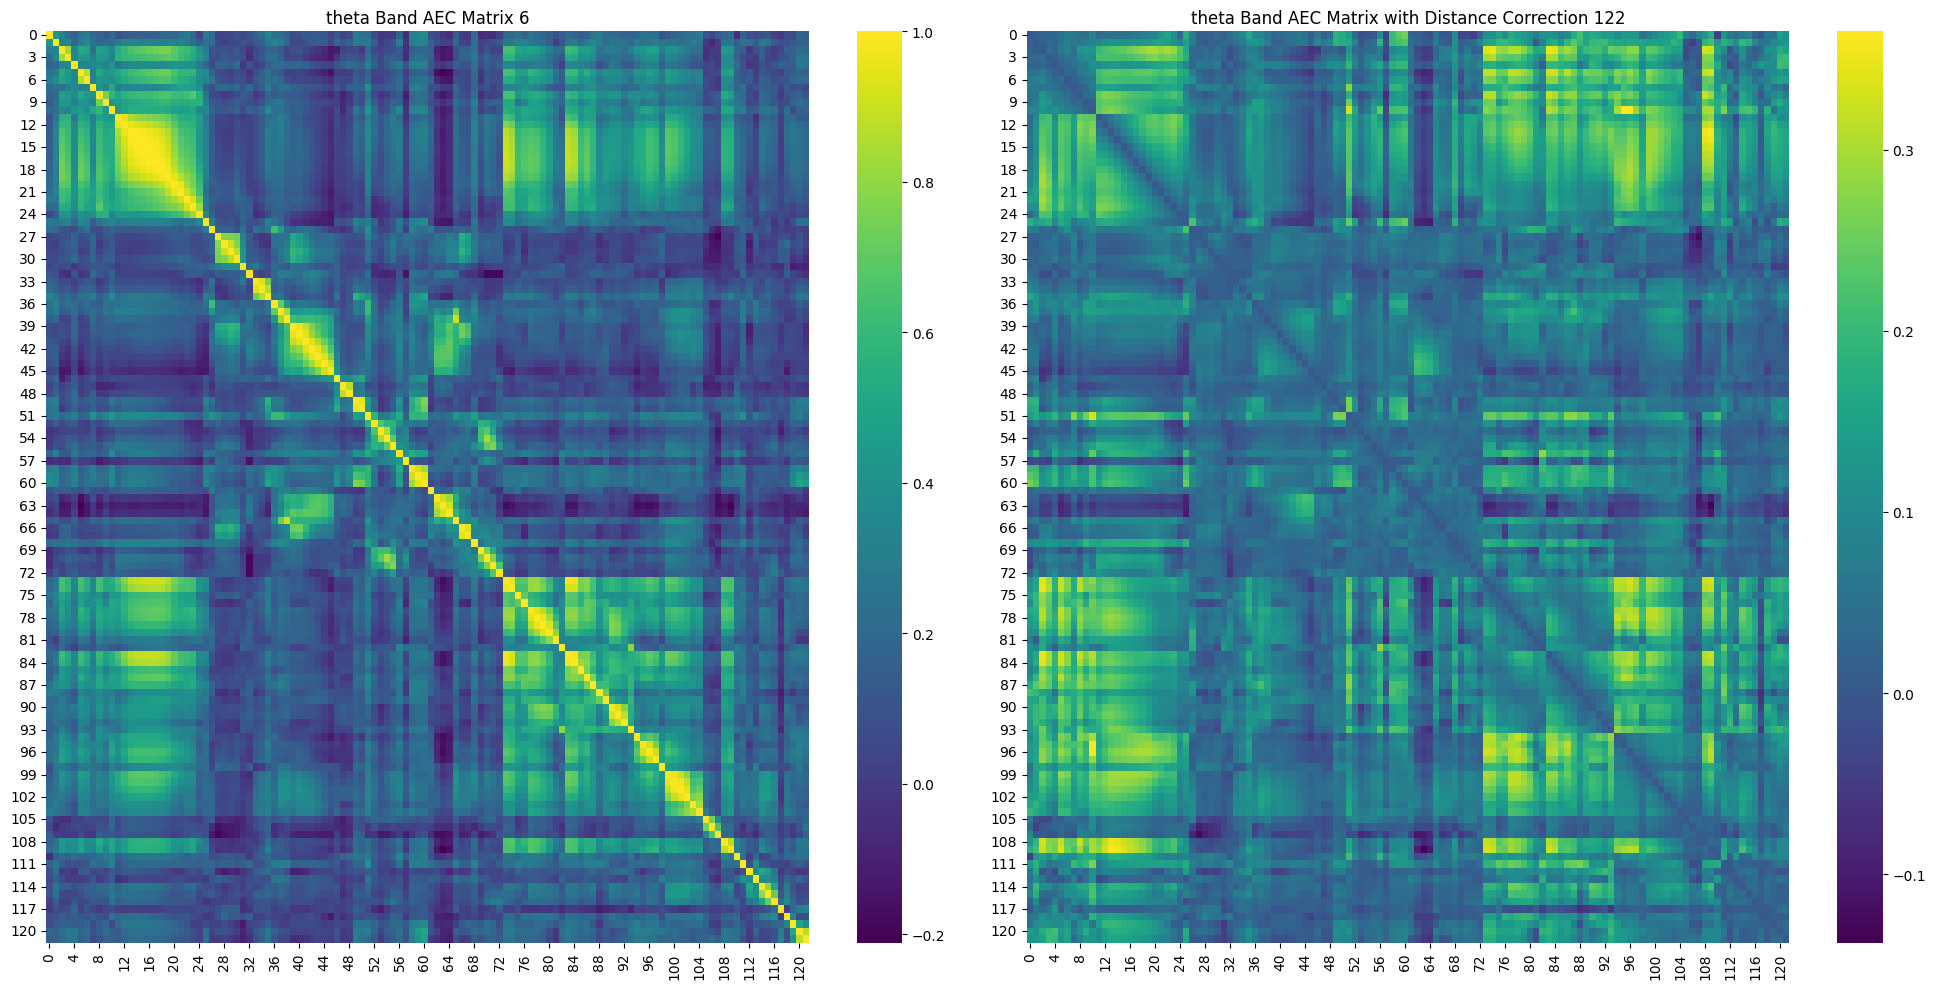

In [22]:
#Lets multiply the AEC matrix by the normalized distance matrix
aec_distance = {}
for band, aec_matrices in aec_results.items():
    aec_distance[band] = []
    for aec_matrix in aec_matrices:
        aec_distance[band].append(aec_matrix * normalized_distances)
    aec_distance[band] = np.array(aec_distance[band])

# Plot the AEC with and without distance correction for an epoch in a band (e.g., 'low_gamma')
band='theta'
t=6

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(aec_results[band][t,:,:], ax=axes[0], cmap='viridis')
axes[0].set_title(f'{band} Band AEC Matrix {t}')
sns.heatmap(aec_distance[band][t,:,:], ax=axes[1], cmap='viridis')
axes[1].set_title(f'{band} Band AEC Matrix with Distance Correction {i + 1}')
plt.tight_layout()
plt.show()

# Reading and preprocessing

In [3]:
data = mne.io.read_raw_edf("/home/pablo/works/dev_thesis_SEEG/data/pte6_1_28_38.edf", preload=True, infer_types=True)
print(f"Total data: {data.n_times}, with a total time of {data.n_times/data.info['sfreq']} seconds")
raw=data.copy().crop(5300, 5900)
print(f"Data reduced to: {raw.n_times} samples, with a total time of {raw.n_times/raw.info['sfreq']} seconds")

Extracting EDF parameters from /teamspace/studios/this_studio/.lightning_studio/EpiPlan /data/pte6_1_28_38.edf...
EDF file detected
Channel 'EEG OF1' recognized as type EEG (renamed to 'OF1').
Channel 'EEG OF2' recognized as type EEG (renamed to 'OF2').
Channel 'EEG OF3' recognized as type EEG (renamed to 'OF3').
Channel 'EEG OF4' recognized as type EEG (renamed to 'OF4').
Channel 'EEG OF5' recognized as type EEG (renamed to 'OF5').
Channel 'EEG OF6' recognized as type EEG (renamed to 'OF6').
Channel 'EEG CR01' recognized as type EEG (renamed to 'CR01').
Channel 'EEG CR02' recognized as type EEG (renamed to 'CR02').
Channel 'EEG CR03' recognized as type EEG (renamed to 'CR03').
Channel 'EEG CR04' recognized as type EEG (renamed to 'CR04').
Channel 'EEG CR05' recognized as type EEG (renamed to 'CR05').
Channel 'EEG CR06' recognized as type EEG (renamed to 'CR06').
Channel 'EEG CR07' recognized as type EEG (renamed to 'CR07').
Channel 'EEG CR08' recognized as type EEG (renamed to 'CR08')

Total data: 2764800, with a total time of 10800.0 seconds
Data reduced to: 153601 samples, with a total time of 600.00390625 seconds


<Info | 8 non-empty values
 bads: []
 ch_names: OF1, OF2, OF3, OF4, OF5, OF6, CR01, CR02, CR03, CR04, CR05, ...
 chs: 130 sEEG
 custom_ref_applied: False
 highpass: 0.1 Hz
 lowpass: 67.0 Hz
 meas_date: 2022-11-10 00:57:15 UTC
 nchan: 130
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>


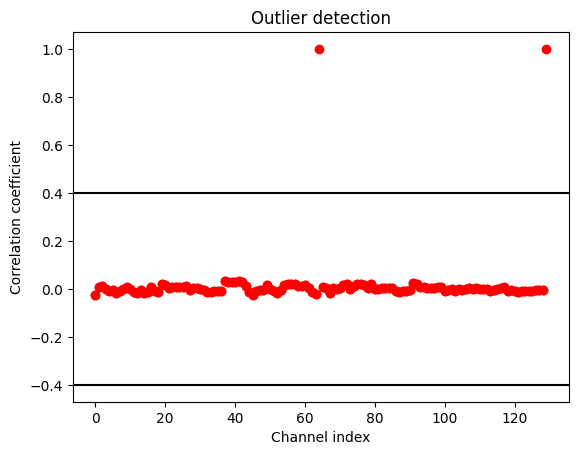

Problematic chanel 1: MKR1+
Problematic chanel 1: MKR2+
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)


/tmp/ipykernel_2236/898367982.py:33: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks=outlier_channels, average=False)


<RawEDF | pte6_1_28_38.edf, 128 x 153601 (600.0 s), ~150.1 MB, data loaded>
 ch  name  type  unit        min         Q1     median         Q3        max
  0  OF1   SEEG  mV        -1.69      -0.05       0.01       0.07       1.07
  1  OF2   SEEG  mV        -2.46      -0.07       0.01       0.09       1.45
  2  OF3   SEEG  mV        -2.78      -0.09       0.00       0.10       2.26
  3  OF4   SEEG  mV        -2.07      -0.05       0.01       0.07       1.34
  4  OF5   SEEG  mV        -2.20      -0.06       0.01       0.08       1.60
  5  OF6   SEEG  mV        -2.45      -0.06       0.01       0.08       1.62
  6  CR01  SEEG  mV        -1.26      -0.04       0.01       0.06       1.41
  7  CR02  SEEG  mV        -1.43      -0.05       0.01       0.06       1.60
  8  CR03  SEEG  mV        -1.53      -0.05       0.01       0.06       2.13
  9  CR04  SEEG  mV        -1.21      -0.05       0.01       0.07       2.58
 10  CR05  SEEG  mV        -1.17      -0.04       0.01       0.06       1.89


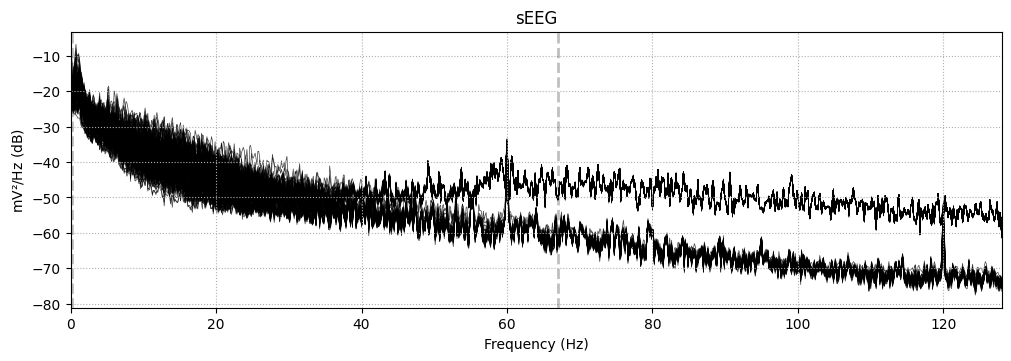

In [4]:
# Get the channel names
ch_names = raw.ch_names

# Dictionary to hold channel types
channel_types = {}

# Set all channel types to 'seeg'
for ch_name in ch_names:
    channel_types[ch_name] = 'seeg'

# Set the channel types
raw.set_channel_types(channel_types)

# Verify that the channel types are correctly set
print(raw.info)
#Using a reference channel
reference_channel = 'MKR2+'
correlation_values = np.corrcoef(raw[reference_channel][0], raw.get_data())[0, 1:]
correlation_threshold = 0.4
outlier_channels = np.where(np.abs(correlation_values) < correlation_threshold)[0]
#Plotting correlation values
fig, ax = plt.subplots()
ax.plot(correlation_values, 'ro')
ax.axhline(correlation_threshold, color='k')
ax.axhline(-correlation_threshold, color='k')
ax.set(title='Outlier detection', xlabel='Channel index', ylabel='Correlation coefficient')
ax.plot(outlier_channels, correlation_values[outlier_channels], 'r.', markersize=12)
plt.show()

print(f'Problematic chanel 1: {raw.ch_names[64]}')
print(f'Problematic chanel 1: {raw.ch_names[129]}')
#Plotting the PSD of the outlier channels
raw.plot_psd(picks=outlier_channels, average=False)

raw.drop_channels([raw.ch_names[64],raw.ch_names[129]])
raw.describe()

In [5]:
channels = raw.ch_names

Using matplotlib as 2D backend.


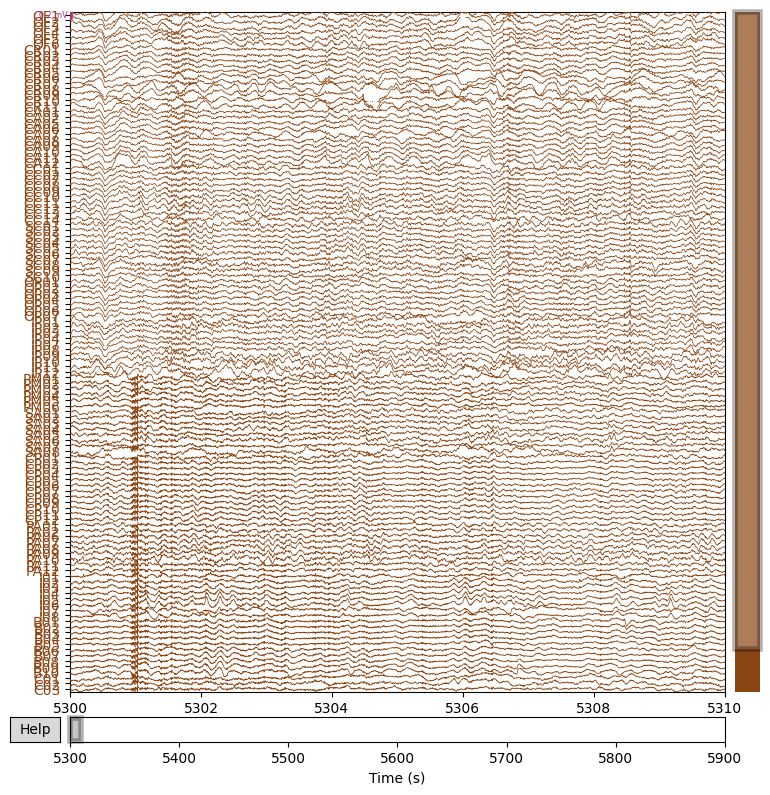

In [6]:
raw.plot(n_channels=120, show_first_samp=True)
plt.show()

In [8]:
raw.save('pte_6_cleaned.fif', overwrite=True)

Overwriting existing file.
Writing /teamspace/studios/this_studio/pte_6_cleaned.fif


/tmp/ipykernel_2236/4162642683.py:1: RuntimeWarning: This filename (/teamspace/studios/this_studio/pte_6_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save('pte_6_cleaned.fif', overwrite=True)


Closing /teamspace/studios/this_studio/pte_6_cleaned.fif
[done]


# Getting EI

In [7]:
Ei_n1, ER_matrix1, U_n_matrix, ER_n_array, alarm_time = get_EI(raw)

Alarm time for channel 0 is 9677.0
Alarm time for channel 1 is 9138.0
Alarm time for channel 2 is 8703.0
Alarm time for channel 3 is 9143.0
Alarm time for channel 4 is 9229.0
Alarm time for channel 5 is 9200.0
Alarm time for channel 6 is 9364.0
Alarm time for channel 7 is 9147.0
Alarm time for channel 8 is 8118.0
Alarm time for channel 9 is 8617.0
Alarm time for channel 10 is 8348.0
Alarm time for channel 11 is 67527.0
Alarm time for channel 12 is 67547.0
Alarm time for channel 13 is 68114.0
Alarm time for channel 14 is 67510.0
Alarm time for channel 15 is 67563.0
Alarm time for channel 16 is 67572.0
Alarm time for channel 17 is 67547.0
Alarm time for channel 18 is 67510.0
Alarm time for channel 19 is 7770.0
Alarm time for channel 20 is 8476.0
Alarm time for channel 21 is 67588.0
Alarm time for channel 22 is 67607.0
Alarm time for channel 23 is 9395.0
Alarm time for channel 24 is 67721.0
Alarm time for channel 25 is 67922.0
Alarm time for channel 26 is 68004.0
Alarm time for channel 27

In [6]:
text="""
Alarm time for channel 0 is 9677.0
Alarm time for channel 1 is 9138.0
Alarm time for channel 2 is 8703.0
Alarm time for channel 3 is 9143.0
Alarm time for channel 4 is 9229.0
Alarm time for channel 5 is 9200.0
Alarm time for channel 6 is 9364.0
Alarm time for channel 7 is 9147.0
Alarm time for channel 8 is 8118.0
Alarm time for channel 9 is 8617.0
Alarm time for channel 10 is 8348.0
Alarm time for channel 11 is 67527.0
Alarm time for channel 12 is 67547.0
Alarm time for channel 13 is 68114.0
Alarm time for channel 14 is 67510.0
Alarm time for channel 15 is 67563.0
Alarm time for channel 16 is 67572.0
Alarm time for channel 17 is 67547.0
Alarm time for channel 18 is 67510.0
Alarm time for channel 19 is 7770.0
Alarm time for channel 20 is 8476.0
Alarm time for channel 21 is 67588.0
Alarm time for channel 22 is 67607.0
Alarm time for channel 23 is 9395.0
Alarm time for channel 24 is 67721.0
Alarm time for channel 25 is 67922.0
Alarm time for channel 26 is 68004.0
Alarm time for channel 27 is 10305.0
Alarm time for channel 28 is 8931.0
Alarm time for channel 29 is 7495.0
Alarm time for channel 30 is 7694.0
Alarm time for channel 31 is 8265.0
Alarm time for channel 32 is 7705.0
Alarm time for channel 33 is 66783.0
Alarm time for channel 34 is 9209.0
Alarm time for channel 35 is 555.0
Alarm time for channel 36 is 67440.0
Alarm time for channel 37 is 67329.0
Alarm time for channel 38 is 9289.0
Alarm time for channel 39 is 8317.0
Alarm time for channel 40 is 8327.0
Alarm time for channel 41 is 8406.0
Alarm time for channel 42 is 7574.0
Alarm time for channel 43 is 7343.0
Alarm time for channel 44 is 1660.0
Alarm time for channel 45 is 854.0
Alarm time for channel 46 is 8526.0
Alarm time for channel 47 is 1908.0
Alarm time for channel 48 is 67512.0
Alarm time for channel 49 is 67195.0
Alarm time for channel 50 is 67240.0
Alarm time for channel 51 is 67104.0
Alarm time for channel 52 is 67360.0
Alarm time for channel 53 is 588.0
Alarm time for channel 54 is 8670.0
Alarm time for channel 55 is 13746.0
Alarm time for channel 56 is 66678.0
Alarm time for channel 57 is 9053.0
Alarm time for channel 58 is 1163.0
Alarm time for channel 59 is 1062.0
Alarm time for channel 60 is 753.0
Alarm time for channel 61 is 838.0
Alarm time for channel 62 is 1783.0
Alarm time for channel 63 is 67507.0
Alarm time for channel 64 is 67253.0
Alarm time for channel 65 is 67282.0
Alarm time for channel 66 is 67320.0
Alarm time for channel 67 is 67253.0
Alarm time for channel 68 is 67293.0
Alarm time for channel 69 is 67146.0
Alarm time for channel 70 is 67104.0
Alarm time for channel 71 is 67173.0
Alarm time for channel 72 is 67158.0
Alarm time for channel 73 is 67321.0
Alarm time for channel 74 is 67248.0
Alarm time for channel 75 is 67235.0
Alarm time for channel 76 is 67269.0
Alarm time for channel 77 is 67320.0
Alarm time for channel 78 is 67030.0
Alarm time for channel 79 is 66989.0
Alarm time for channel 80 is 66972.0
Alarm time for channel 81 is 67067.0
Alarm time for channel 82 is 67128.0
Alarm time for channel 83 is 67243.0
Alarm time for channel 84 is 67256.0
Alarm time for channel 85 is 67235.0
Alarm time for channel 86 is 67275.0
Alarm time for channel 87 is 67259.0
Alarm time for channel 88 is 67231.0
Alarm time for channel 89 is 67206.0
Alarm time for channel 90 is 67241.0
Alarm time for channel 91 is 67212.0
Alarm time for channel 92 is 67141.0
Alarm time for channel 93 is 67194.0
Alarm time for channel 94 is 67239.0
Alarm time for channel 95 is 67261.0
Alarm time for channel 96 is 67253.0
Alarm time for channel 97 is 67238.0
Alarm time for channel 98 is 67159.0
Alarm time for channel 99 is 67212.0
Alarm time for channel 100 is 67132.0
Alarm time for channel 101 is 67125.0
Alarm time for channel 102 is 67177.0
Alarm time for channel 103 is 67265.0
Alarm time for channel 104 is 67295.0
Alarm time for channel 105 is 67259.0
Alarm time for channel 106 is 67167.0
Alarm time for channel 107 is 68200.0
Alarm time for channel 108 is 67713.0
Alarm time for channel 109 is 67255.0
Alarm time for channel 110 is 66984.0
Alarm time for channel 111 is 66904.0
Alarm time for channel 112 is 67178.0
Alarm time for channel 113 is 66961.0
Alarm time for channel 114 is 66919.0
Alarm time for channel 115 is 66945.0
Alarm time for channel 116 is 66922.0
Alarm time for channel 117 is 67173.0
Alarm time for channel 118 is 67063.0
Alarm time for channel 119 is 67194.0
Alarm time for channel 120 is 67014.0
Alarm time for channel 121 is 66861.0
Alarm time for channel 122 is 66763.0
Alarm time for channel 123 is 66650.0
Alarm time for channel 124 is 66686.0
Alarm time for channel 125 is 66883.0
Alarm time for channel 126 is 67109.0
Alarm time for channel 127 is 67223.0
"""

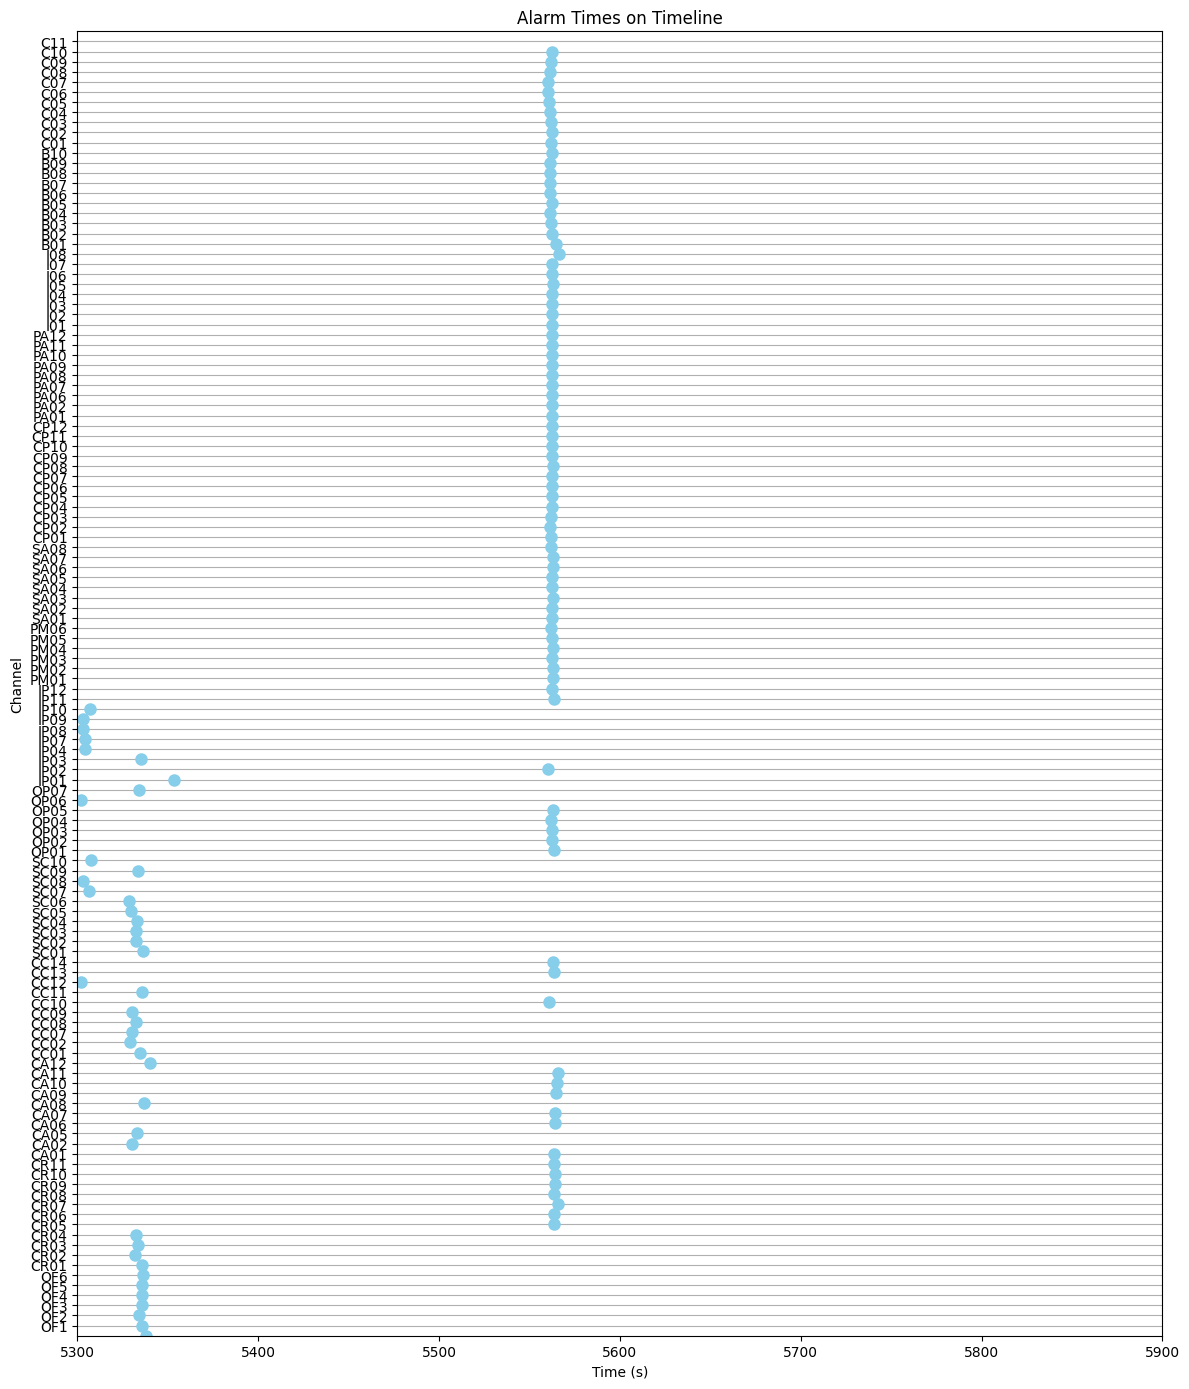

In [21]:
# Data
# Constants
sample_rate = 256  # Hz
t0 = 5300
tf = 5900
total_time = tf - t0  # seconds

data = {
    "channel": [],
    "alarm_time": []
}

lines = text.split("\n")
for line in lines:
    if line.strip():
        channel, alarm_time = line.split(" is ")
        data["channel"].append(channel.split()[-1])
        data["alarm_time"].append(float(alarm_time))

# Transform alarm times to timestamps
timestamps = []
for alarm_time in data["alarm_time"]:
    timestamp = t0 + alarm_time / sample_rate
    timestamps.append(timestamp)

# Plotting
plt.figure(figsize=(12, 14))
for channel, timestamp in zip(data["channel"], timestamps):
    plt.plot(timestamp, channel, 'o', markersize=8, color='skyblue')
plt.xlabel('Time (s)')
plt.ylabel('Channel')
plt.title('Alarm Times on Timeline')
plt.xlim(t0, tf)
plt.ylim(0, len(data["channel"]) + 1)
plt.yticks(np.arange(1, len(data["channel"]) + 1), channels)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
#Ei_n2, ER_matrix2, U_n_matrix, ER_n_array, alarm_time = get_EI_optimal_lambda_vs1(raw, np.arange(0,300,50))

Calculating optimal lambda for channel  0
lambda is  0
Total alarm times are  107620
Current best lambda is  0
Current best alarm times are  294501
-------------------
lambda is  50
Total alarm times are  105580
Current best lambda is  0
Current best alarm times are  107620
-------------------
lambda is  100
Total alarm times are  105406
Current best lambda is  50
Current best alarm times are  105580
-------------------
lambda is  150
Total alarm times are  105261
Current best lambda is  100
Current best alarm times are  105406
-------------------
lambda is  200
Total alarm times are  105118
Current best lambda is  150
Current best alarm times are  105261
-------------------
lambda is  250
Total alarm times are  104946
Current best lambda is  200
Current best alarm times are  105118
-------------------
---> Optimal lambda for channel  0  is  250
-------------------
Calculating optimal lambda for channel  1
lambda is  0
Total alarm times are  105788
Current best lambda is  0
Current bes

In [ ]:
#Ei_n3, ER_matrix3, U_n_matrix, ER_n_array, alarm_time, derivates_d1_matrix, derivates_d2_matrix = get_ei_optimal_vs2(raw)

Alarm time for channel 0 is 191159.0
Alarm time for channel 1 is 210015.0
Alarm time for channel 2 is 259380.0
Alarm time for channel 3 is 255280.0
Alarm time for channel 4 is 250282.0
Alarm time for channel 5 is 250282.0
Alarm time for channel 6 is 217393.0
Alarm time for channel 7 is 222394.0
Alarm time for channel 8 is 217393.0
Alarm time for channel 9 is 217393.0
Alarm time for channel 10 is 222586.0
Alarm time for channel 11 is 258492.0
Alarm time for channel 12 is 255280.0
Alarm time for channel 13 is 217393.0
Alarm time for channel 14 is 153194.0
Alarm time for channel 15 is 152337.0
Alarm time for channel 16 is 255280.0
Alarm time for channel 17 is 258475.0
Alarm time for channel 18 is 152807.0
Alarm time for channel 19 is 152117.0
Alarm time for channel 20 is 217393.0
Alarm time for channel 21 is 259379.0


In [29]:
def plotting_ei(Ei_n, ER_matrix,channels, derivatives_d1=None):
    if derivatives_d1 is None:
        plt.imshow(ER_matrix1, cmap='viridis', interpolation='bicubic', aspect='auto')
        ## colorbar
        plt.colorbar()
        plt.yticks(np.arange(len(channels)), channels, fontsize=4)  # Rotate the labels horizontally
        plt.xlabel('Window number')
        plt.ylabel('Channel name')
        plt.title('ER_n')
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

        #Plting a barplt of the EI values for every channel
        #widther figure
        plt.figure(figsize=(20,5))
        plt.bar(channels,Ei_n)
        plt.xlabel('Channel name')
        #90 degrees rotation
        plt.xticks(rotation=90)
        plt.ylabel('EI')
        plt.show()
    else:
        plt.imshow(ER_matrix,cmap='viridis',interpolation='bicubic',aspect='auto',extent=[0,40000,0,22])
        #colorbar
        plt.colorbar()
        plt.yticks(np.arange(len(channels)), channels)
        plt.xlabel('Window number')
        plt.ylabel('Channel name')
        plt.title('ER_n')
        plt.show()

        #Plting a barplt of the EI values for every channel
        plt.bar(channels,Ei_n)
        plt.xlabel('Channel name')
        plt.ylabel('EI')
        plt.show()

        plt.imshow(derivatives_d1,cmap='viridis',interpolation='bicubic',aspect='auto',extent=[0,40000,0,22])
        #colorbar
        plt.colorbar()
        plt.yticks(np.arange(len(channels)), channels)
        plt.xlabel('Window number')
        plt.ylabel('Channel name')
        plt.title('ER_n')
        plt.show()

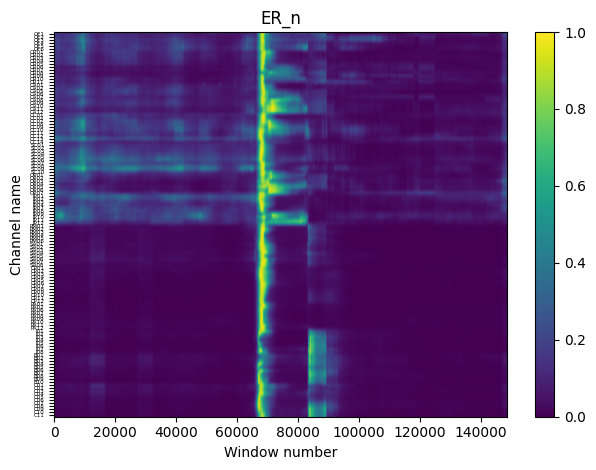

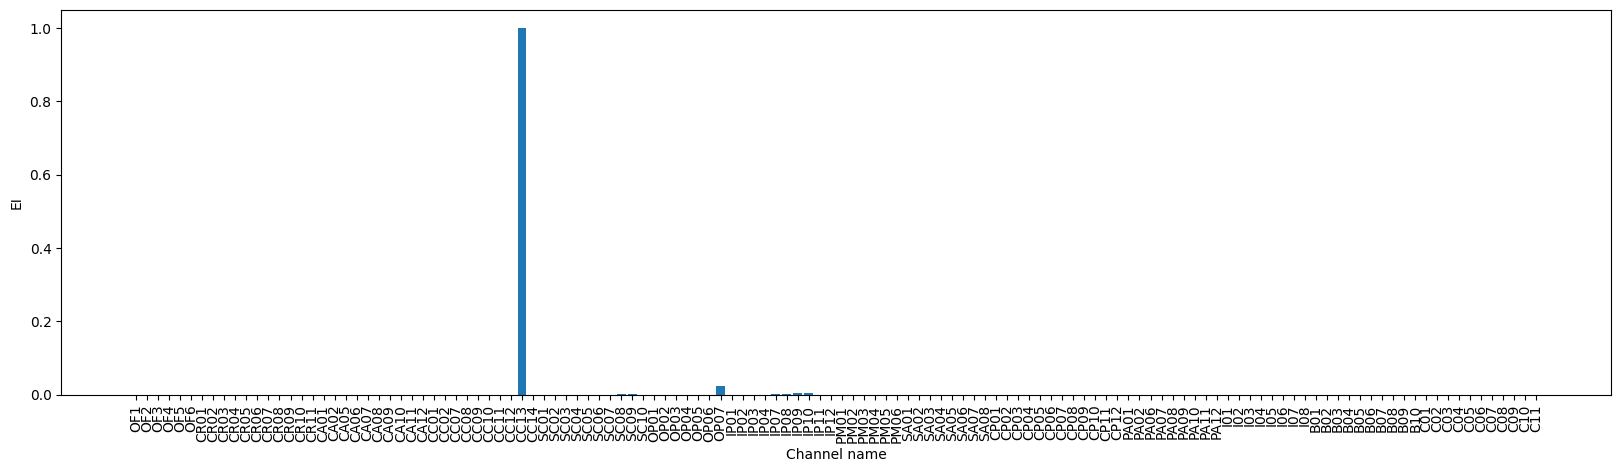

In [30]:
plotting_ei(Ei_n1, ER_matrix1, channels)
#plotting_ei(Ei_n2, ER_matrix2, channels)
#plotting_ei(Ei_n3, ER_matrix3, channels,derivates_d1_matrix)

# Connectivity Measures

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 25600 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 8128 connections
    using t=0.000s..99.996s for estimation (25600 points)
    frequencies: 4.0Hz..9.0Hz (501 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    assembling connectivity matrix
[Connectivity computation done]
Replacing existi

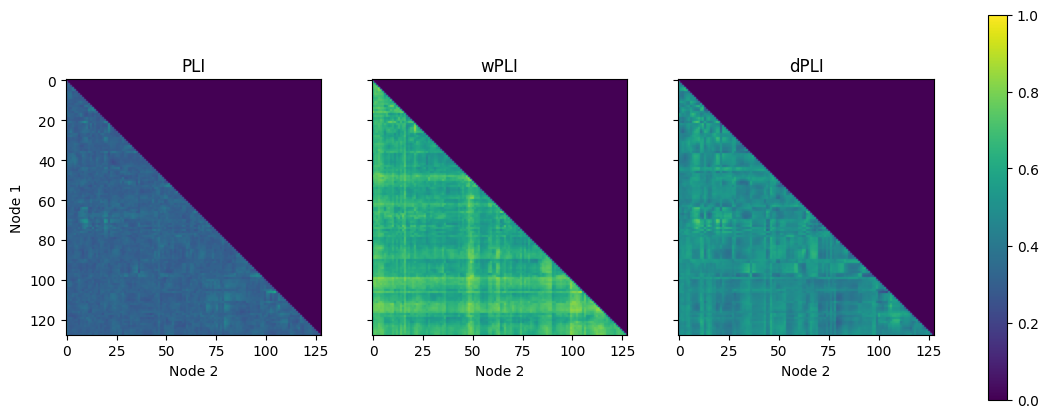

In [12]:
con_pli, con_wpli,con_dpli=compute_connectivity(raw)

Not setting metadata
6 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 6 events and 25600 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 8128 connections
    using t=0.000s..99.996s for estimation (25600 points)
    computing connectivity for the bands:
     band 1: 8.0Hz..13.0Hz (501 points)
     band 2: 13.0Hz..30.0Hz (1701 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
 

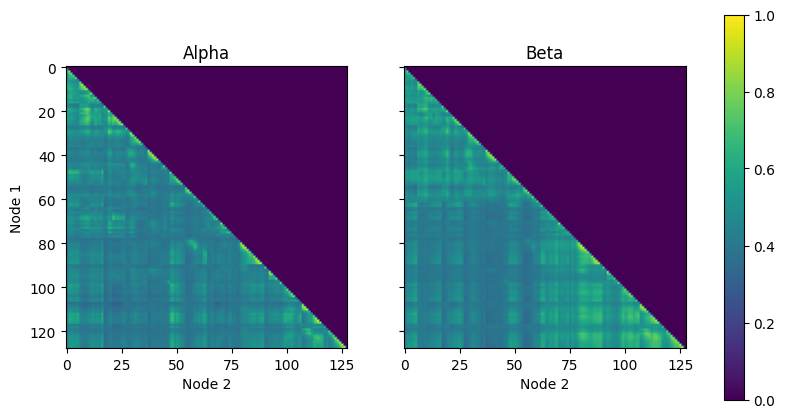

In [11]:
coh =compute_coherence(raw)

# Correlation for graph connection 

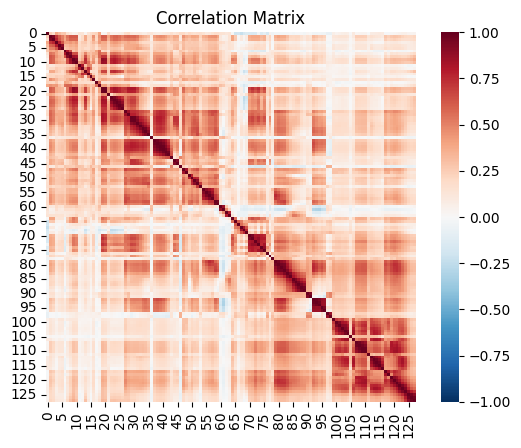

Adjacency matrix for Correlation matrix


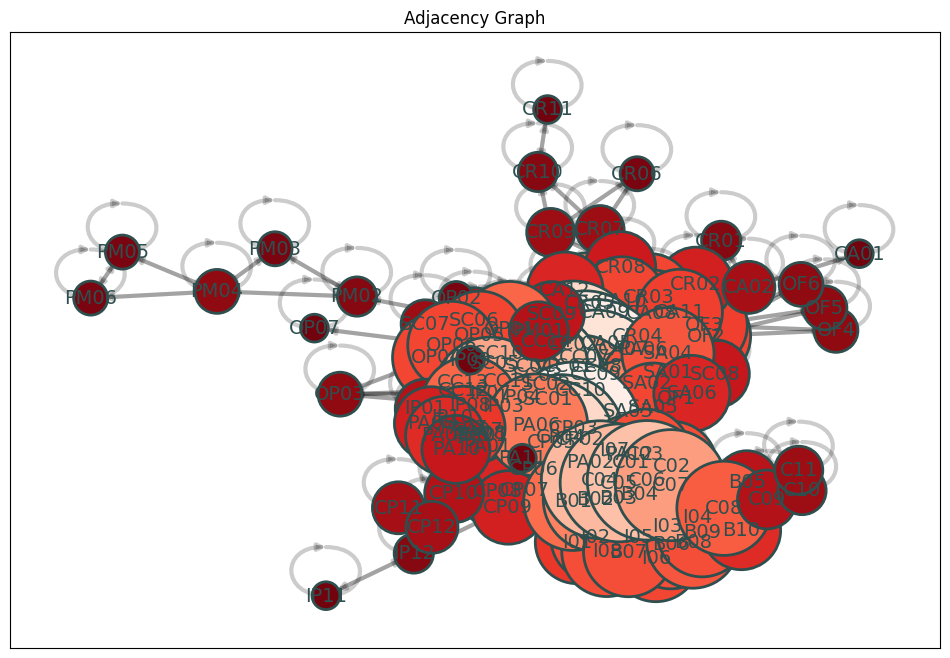

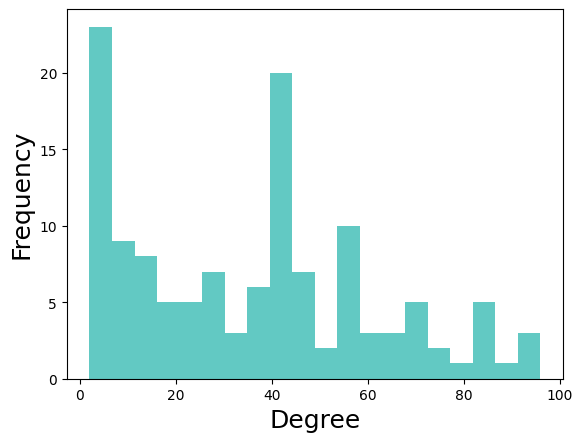

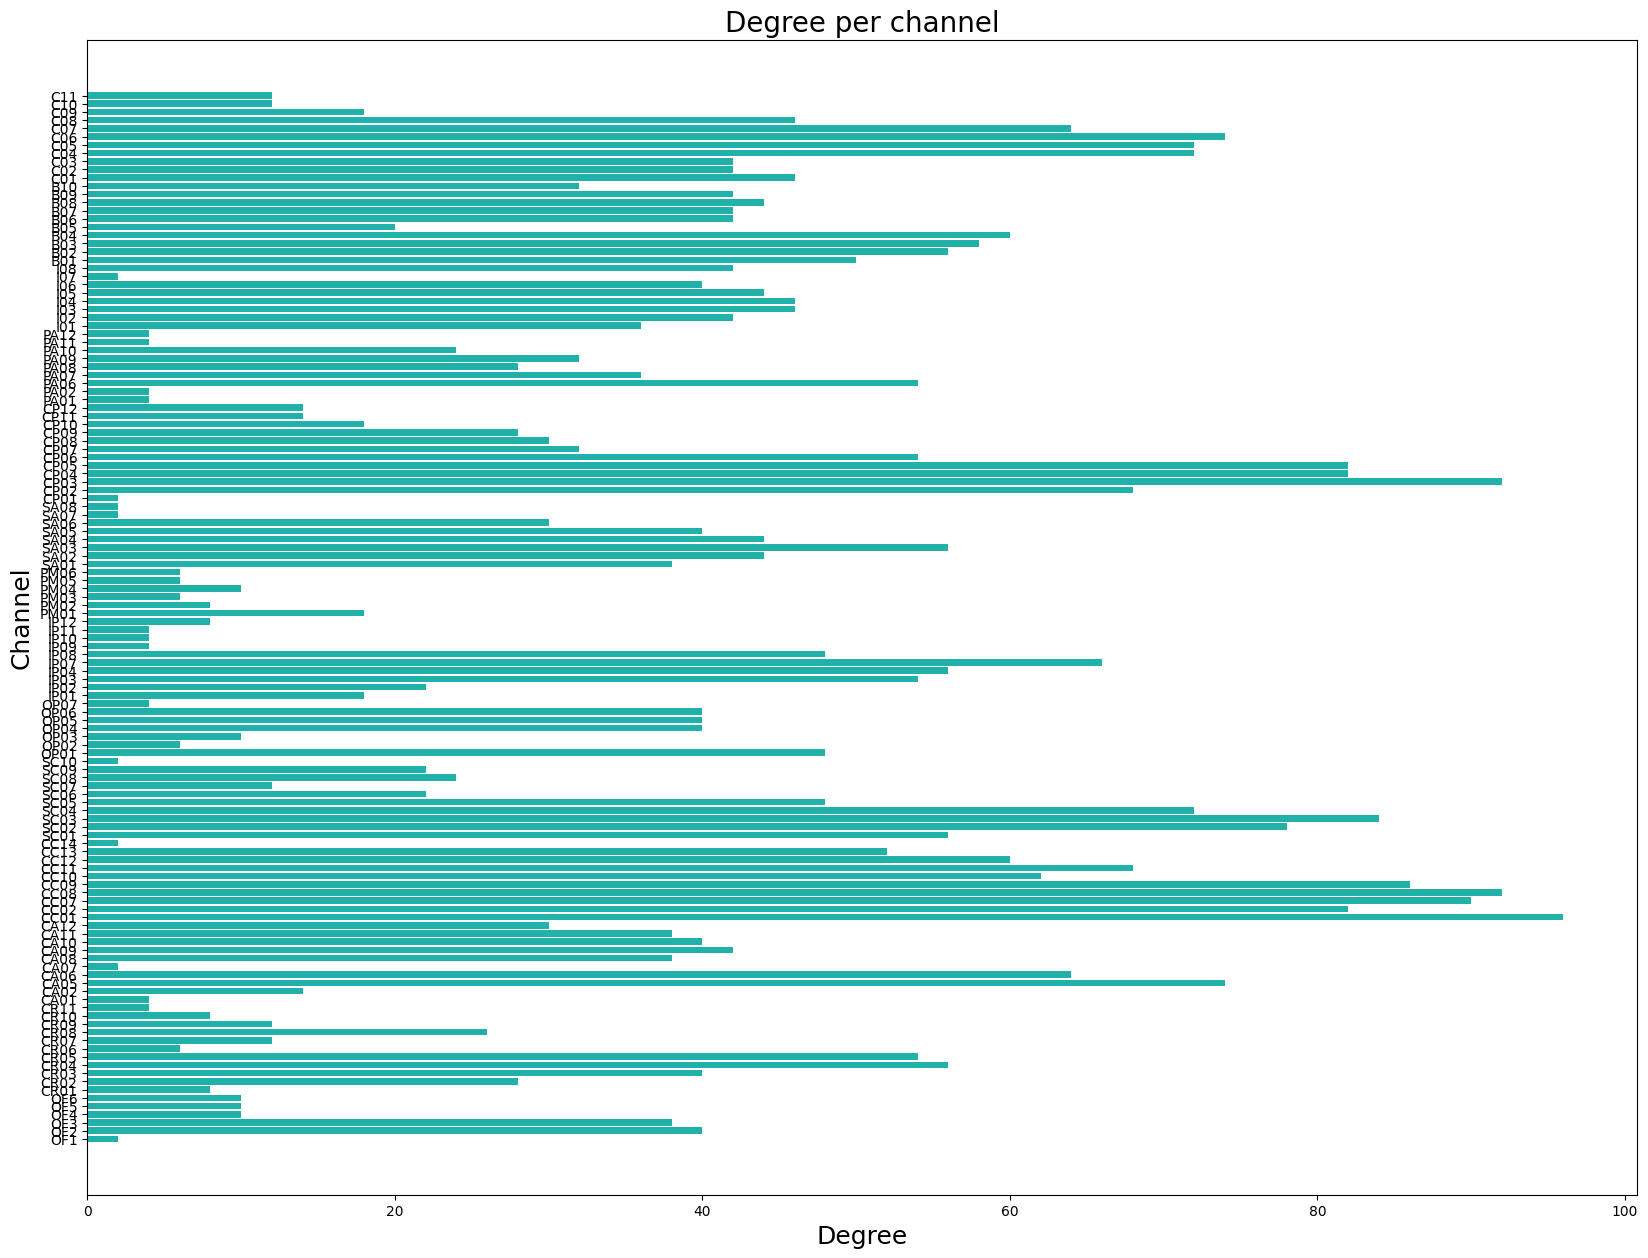

In [12]:
a_thresholded,G=compute_adjacency_graph(raw)

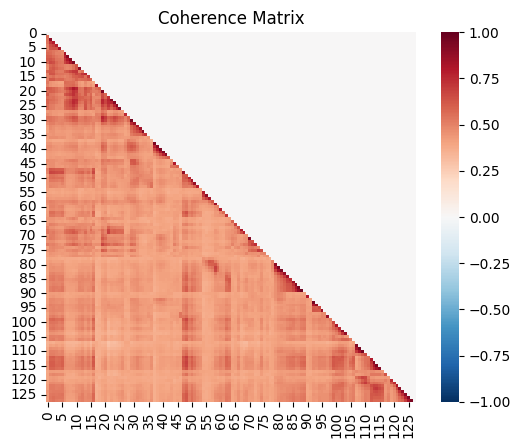

Adjacency matrix for Coherence matrix


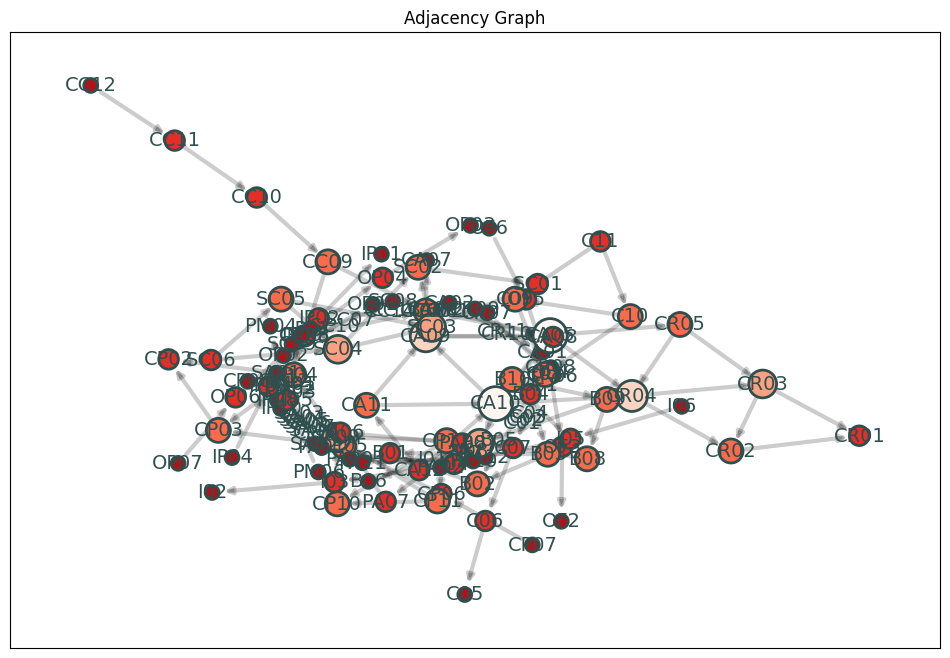

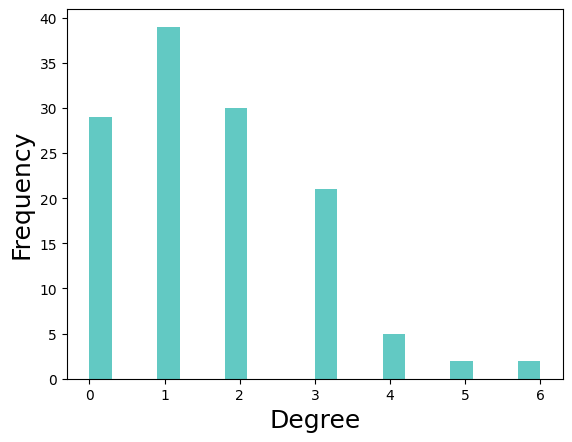

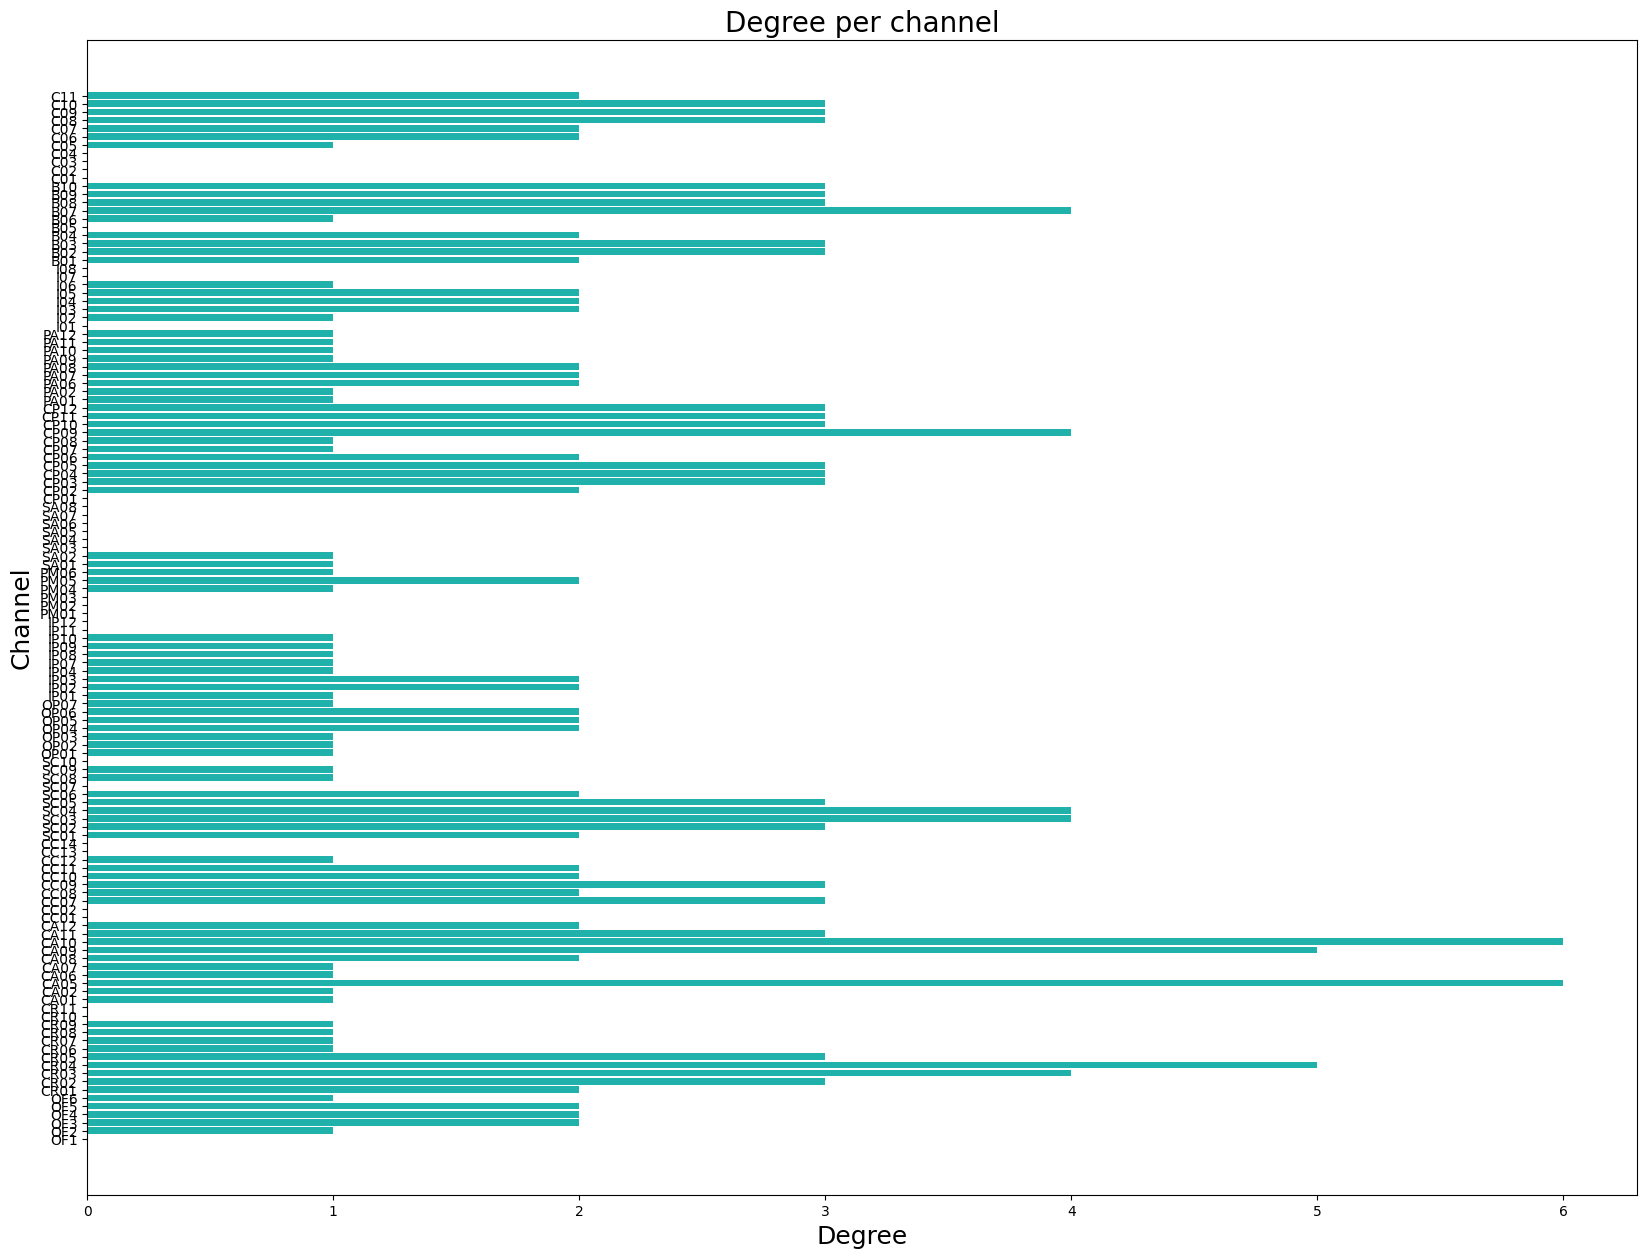

In [13]:
a_thresholded,G=compute_adjacency_graph(raw,coh[:,:,0],"Coherence",0.75)

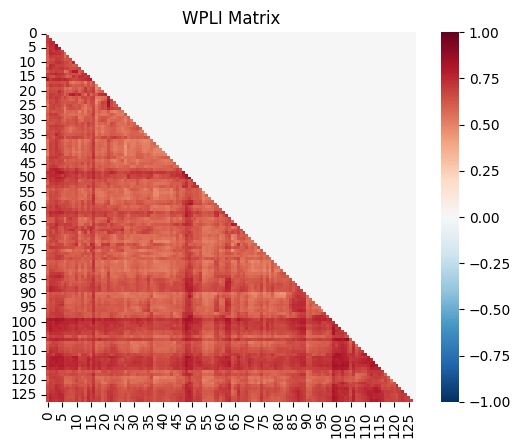

Adjacency matrix for WPLI matrix


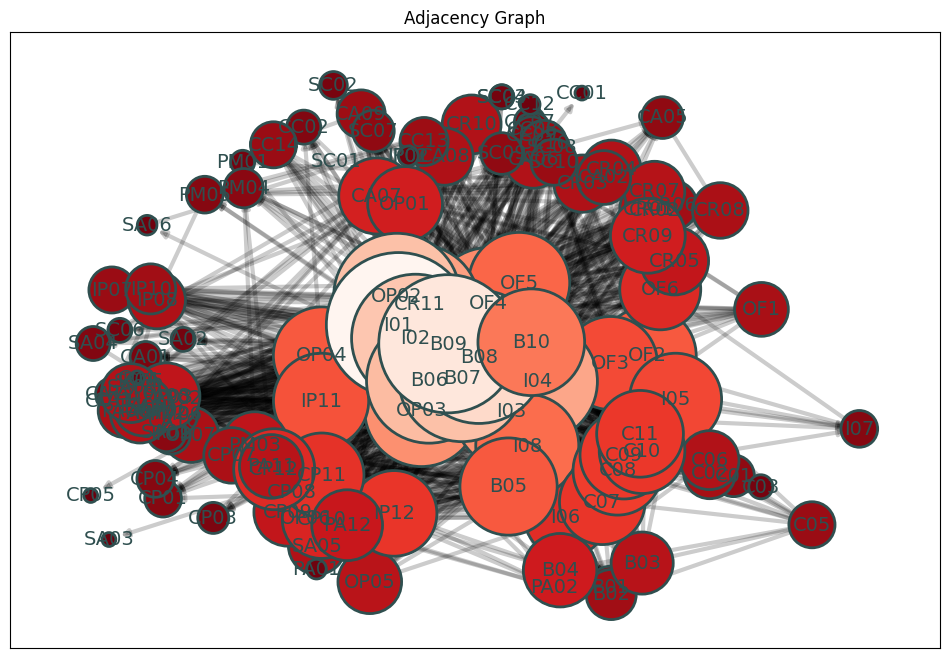

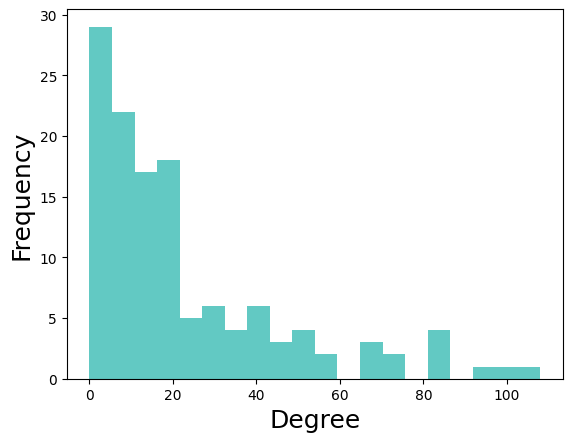

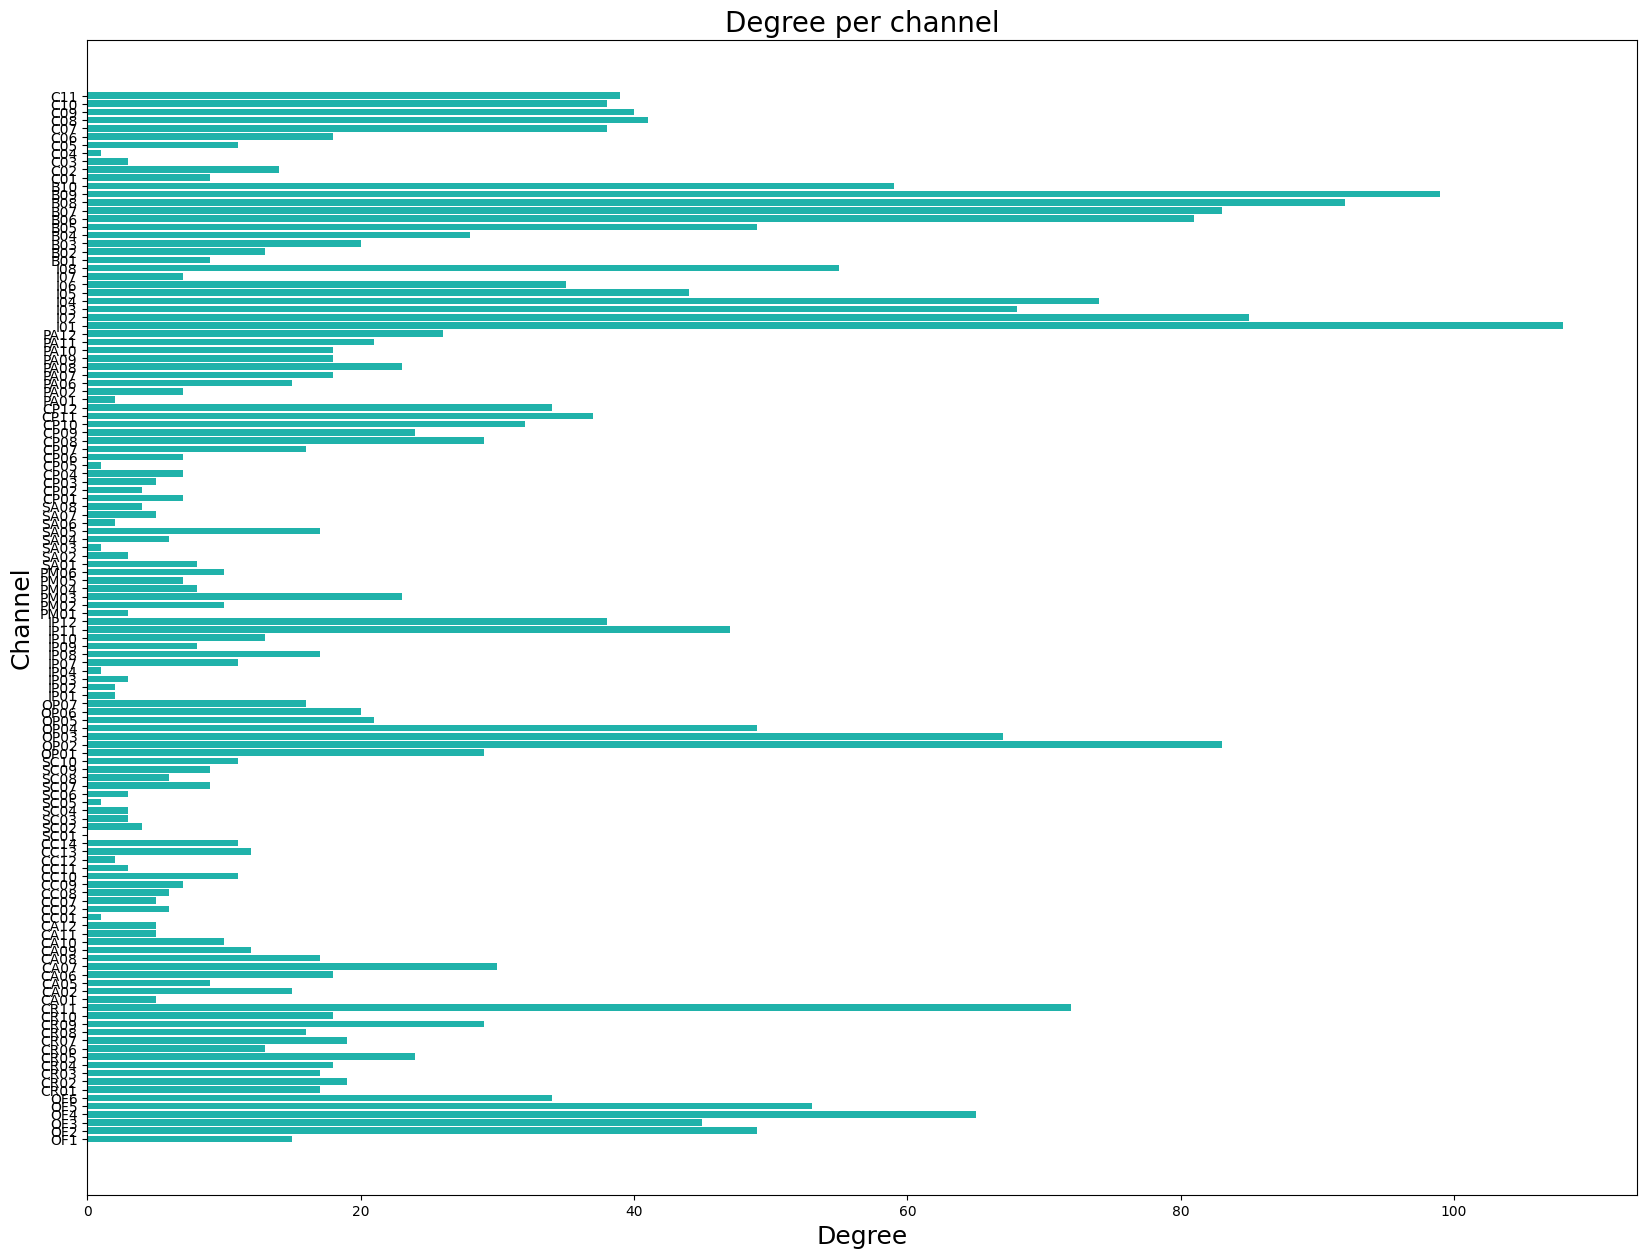

In [13]:
a_thresholded,G=compute_adjacency_graph(raw,con_wpli[:,:,0],"WPLI",0.7)

### Granger Connectivity

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12 events and 12800 original time points ...
0 bad epochs dropped
Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_1855/1469543472.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs.plot_image(picks=['OF1'],cmap='RdBu_r')


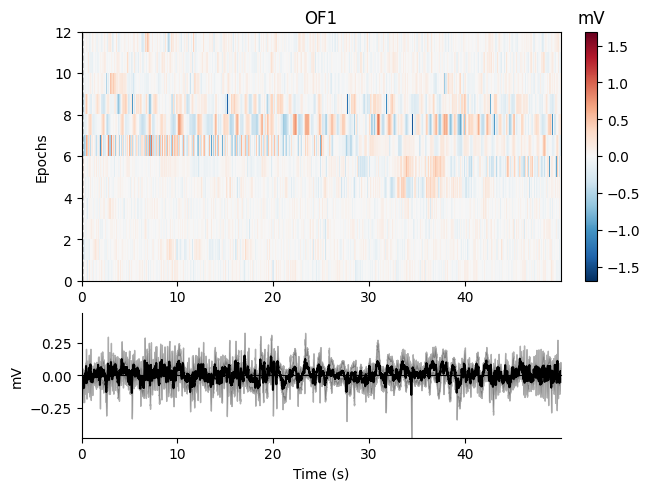

OF: [0, 1, 2, 3, 4, 5]
CR: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
CA: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
CC: [27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
SC: [37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
OP: [47, 48, 49, 50, 51, 52, 53]
IP: [54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
PM: [64, 65, 66, 67, 68, 69]
SA: [70, 71, 72, 73, 74, 75, 76, 77]
CP: [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]
PA: [90, 91, 92, 93, 94, 95, 96, 97, 98]
I: [99, 100, 101, 102, 103, 104, 105, 106]
B: [107, 108, 109, 110, 111, 112, 113, 114, 115, 116]
C: [117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]


In [22]:
epochs=mne.make_fixed_length_epochs(raw, duration=50.0, preload=True)
epochs.plot_image(picks=['OF1'],cmap='RdBu_r')

# Group channels based on their prefixes
channel_groups = {}
for idx, channel in enumerate(epochs.info['ch_names']):
  prefix = ''.join(filter(str.isalpha, channel))
  if prefix in channel_groups:
    channel_groups[prefix].append(idx)
  else:
    channel_groups[prefix] = [idx]

for prefix, channels in channel_groups.items():
    print(f'{prefix}: {channels}')

Adding metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..49.996s for estimation (12800 points)
    frequencies: 5.0Hz..30.0Hz (1251 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
Computing GC for connection 1 of 1


  0%|          | frequency blocks : 0/1251 [00:00<?,       ?it/s]

[Connectivity computation done]
Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..49.996s for estimation (12800 points)
    frequencies: 5.0Hz..30.0Hz (1251 points)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
Computing GC for connection 1 of 1


  0%|          | frequency blocks : 0/1251 [00:00<?,       ?it/s]

[Connectivity computation done]


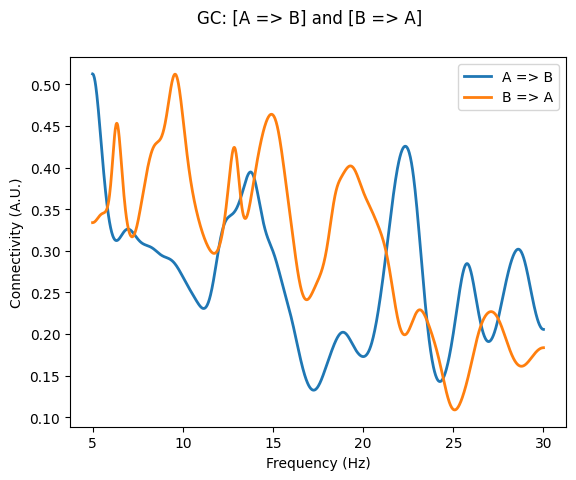

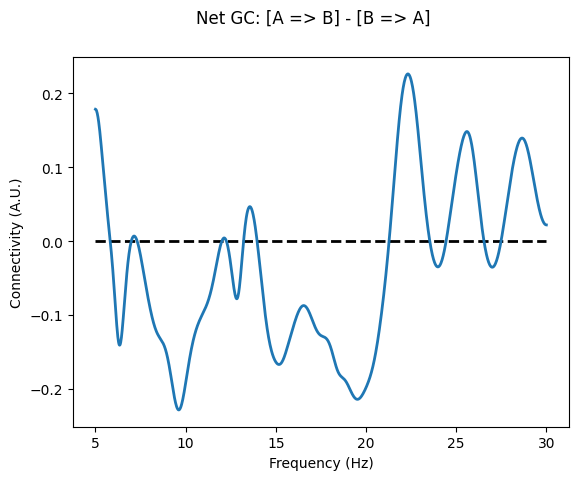

In [23]:
gc_ab, gc_ba, freqs = calculate_and_plot_granger_causality(epochs, channel_groups['CC'], channel_groups['OP'])

Replacing existing metadata with 3 columns
Connectivity computation...
    computing connectivity for 1 connections
    using t=0.000s..49.996s for estimation (12800 points)
    frequencies: 5.0Hz..30.0Hz (1251 points)
Estimated data ranks:
    connection 1 - seeds (10); targets (7)
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: GC
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoch 12
Computing GC for 

  0%|          | frequency blocks : 0/1251 [00:00<?,       ?it/s]

[Connectivity computation done]


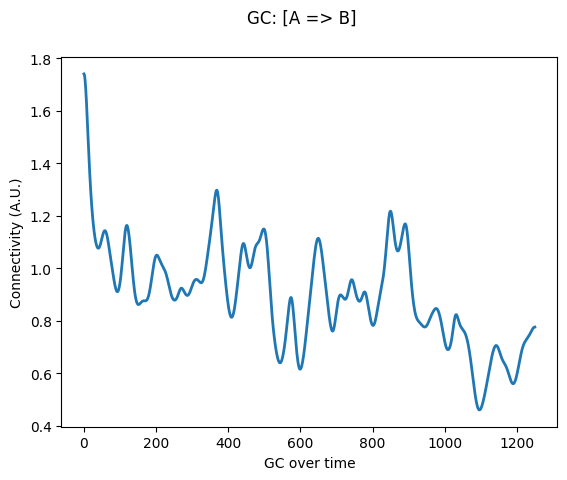

In [26]:
sfreq = epochs.info["sfreq"]  # the sampling frequency
tmin = 0.0  # exclude the baseline period for connectivity estimation
Freq_Bands = {"theta": [5, 30]}  # frequency of interest
indices_ab = (np.array([channel_groups['CC']]), np.array([channel_groups['OP']]))  # A => B

n_freq_bands = len(Freq_Bands)
min_freq = np.min(list(Freq_Bands.values()))
max_freq = np.max(list(Freq_Bands.values()))

# Prepare the freq points
freqs = np.linspace(min_freq, max_freq, int((max_freq - min_freq) * 4 + 1))

fmin = tuple([list(Freq_Bands.values())[f][0] for f in range(len(Freq_Bands))])
fmax = tuple([list(Freq_Bands.values())[f][1] for f in range(len(Freq_Bands))])

# We specify the connectivity measurements
connectivity_methods = ["gc"]
n_con_methods = len(connectivity_methods)


#Interesting channels according

# Compute connectivity over trials
con_epochs = spectral_connectivity_epochs(
    epochs,
    method=connectivity_methods,
    sfreq=sfreq,
    indices=indices_ab,
    fmin=fmin,
    fmax=fmax
)

con_data=np.sum(con_epochs.get_data(output="raveled"), axis=0)
#plotting
fig, axis = plt.subplots(1, 1)
axis.plot(con_data, linewidth=2)
axis.set_xlabel("GC over time")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("GC: [A => B]")
plt.show()